# Label Propagation: Benchmarking Pipeline

This notebook contains the pipeline that helps create benchmarks on different datasets using one of the following approaches:
1. Point Label Aware Superpixels approach
2. SAM -  Multiple "Points Based Prompting" followed by Masks Blending
3. SAM-HQ - Multiple "Points Based Prompting" followed by Masks Blending

## Setups

### Logger Setup

In [1]:
import logging

In [2]:
# define a formatter to display the messages to console (standard output)
console_formatter = logging.Formatter('%(message)s')
# console_formatter = logging.Formatter('%(levelname)s:%(module)s:%(message)s')
console_handler = logging.StreamHandler()
console_handler.setFormatter(console_formatter)

In [3]:
# define a logger for this notebook and attach the console handler
logger = logging.getLogger('Label-Propagation')
logger.handlers.clear()
logger.propagate = False
logger.addHandler(console_handler)

In [4]:
# set an appropriate level of logging for this notebook
logger.setLevel(logging.INFO)

### Mount GCS Bucket

References:
1. [Mount a Cloud Storage bucket using Cloud Storage FUSE](https://cloud.google.com/storage/docs/gcsfuse-quickstart-mount-bucket)
2. [Snippets: Saving Data to Google Cloud Storage](https://colab.research.google.com/notebooks/snippets/gcs.ipynb)
3. [Connect Colab to GCS Bucket Using gcsfuse](https://pub.towardsai.net/connect-colab-to-gcs-bucket-using-gcsfuse-29f4f844d074)

**Authentication**

This step authenticates the user in order to access Google Storage Bucket using an authenticated account.

In [5]:
from google.colab import auth
auth.authenticate_user()

**Install Cloud Storage FUSE**

1. Add the Cloud Storage FUSE distribution URL as a package source:

In [6]:
# check if gcsfuse.list file exists at the path it normally resides
!ls /etc/apt/sources.list.d

archive_uri-https_cloud_r-project_org_bin_linux_ubuntu-jammy.list
c2d4u_team-ubuntu-c2d4u4_0_-jammy.list
cuda-ubuntu2204-x86_64.list
deadsnakes-ubuntu-ppa-jammy.list
graphics-drivers-ubuntu-ppa-jammy.list
ubuntugis-ubuntu-ppa-jammy.list


In [7]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

cat: /etc/apt/sources.list.d/gcsfuse.list: No such file or directory


In [8]:
# add Cloud Storage FUSE distribution URL as a package source
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


In [9]:
# open gcsfuse.list file and show its contents
!cat /etc/apt/sources.list.d/gcsfuse.list

deb https://packages.cloud.google.com/apt gcsfuse-jammy main


2. Import the Google Cloud APT repository public key and add it to your list of keys:

In [10]:
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0Warning: apt-key is deprecated. Manage keyring files in trusted.gpg.d instead (see apt-key(8)).
100  2659  100  2659    0     0  21095      0 --:--:-- --:--:-- --:--:-- 21272
OK


3. Updates the list of available packages and install gcsfuse:

In [11]:
!apt -qq update && apt -qq install gcsfuse

26 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 26 not upgraded.
Need to get 5,415 kB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ... 121654 files and directories currently installed.)
Preparing to unpack .../gcsfuse_1.4.0_amd64.deb ...
Unpacking gcsfuse (1.4.0) ...
Setting up gcsfuse (1.4.0) ...


In [12]:
# check if gcsfuse is installed
!gcsfuse -v

gcsfuse version 1.4.0 (Go version go1.21.5)


**Mount Bucket on Colab Disk**

Initialize bucket name and the folder on Colab on which the bucket will be mounted

In [13]:
BUCKET_NAME = 'rs_storage_open'
BUCKET_MOUNT_DIR = f"/mnt/gs/{BUCKET_NAME}"

Create a directory to mount the storage bucket to

In [14]:
!mkdir -p {BUCKET_MOUNT_DIR}

In [15]:
!ls -l /mnt/gs

total 4
drwxr-xr-x 2 root root 4096 Jan 16 06:47 rs_storage_open


Mount your storage bucket using the gcsfuse command:

In [16]:
!gcsfuse --implicit-dirs {BUCKET_NAME} {BUCKET_MOUNT_DIR}

{"time":"16/01/2024 06:47:15.710681","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /mnt/gs/rs_storage_open\n"}


In [17]:
!ls -l {BUCKET_MOUNT_DIR}

total 9
drwxr-xr-x 1 root root    0 Jan 16 06:47 benthic_datasets
-rw-r--r-- 1 root root 8514 Nov 14 13:31 README.md


### Mount Google Drive

In [18]:
import os
from google.colab import drive

In [19]:
DRIVE_MOUNT_DIR = '/content/drive'
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

Mounted at /content/drive


### Directory Setup

Local Root Directory

In [20]:
# local root directory for this notebook
LOCAL_ROOT_DIR = '/content'

Bucket Mount Directory

In [21]:
# Root folder for dataset
logger.info(f"Root directory for dataset: {BUCKET_MOUNT_DIR}")

Root directory for dataset: /mnt/gs/rs_storage_open


Project Root Directory

In [22]:
# Root folder in Google Drive for this project
PROJECT_ROOT_DIR = os.path.join(DRIVE_MOUNT_DIR, 'MyDrive', '20231114-FruitPunch-AI-for-Coral-Reefs-2')
logger.info(f"Root directory for project in Google Drive: {PROJECT_ROOT_DIR}")

Root directory for project in Google Drive: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2


### Custom Libraries

In [23]:
import sys

In [24]:
# add the path where point label aware superpixels and custom packags is located
sys.path.append(os.path.join(PROJECT_ROOT_DIR, 'packages'))

### Dependencies

In [25]:
import torch

In [26]:
# workaround to overcome long duration needed for installing torch_scatter
!pip install pyg_lib torch_scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html

Looking in links: https://data.pyg.org/whl/torch-2.1.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 60.7 MB/s eta 0:00:00


In [27]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 7.4 MB/s eta 0:00:00


In [28]:
!pip install 'git+https://github.com/facebookresearch/segment-anything.git'

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-0l0pi7kl
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-0l0pi7kl
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment-anything: filename=segment_anything-1.0-py3-none-any.whl size=36587 sha256=a111dec1c568efdb2f560d27c8ab5896caebef7e3e4c0aa084ab872a4980a330
  Stored in directory: /tmp/pip-ephem-wheel-cache-ti537krk/wheels/10/cf/59/9ccb2f0a1bcc81d4fbd0e501680b5d088d690c6cfbc02dc99d
Successfully built segment-anything


In [29]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 8.5 MB/s eta 0:00:00


In [30]:
!pip install segment-anything-hq

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 392.0 kB/s eta 0:00:00


In [31]:
import cv2
import yaml
import pandas as pd
import albumentations

from pathlib import Path

In [32]:
from labelmate.loader import LabelPropDataLoader
from labelmate.patchifier import SimplePatchifier
from labelmate.visualizer import visualize_output
from labelmate.evaluator import LabelPropEvaluator
from labelmate.propagator import PLASPIXLabelProp, SAMPointPromptsLabelProp

In [33]:
custom_modules = ['labelmate.loader', 'labelmate.visualizer',
                  'labelmate.evaluator', 'labelmate.propagator',
                  'labelmate.hypertuner', 'labelmate.patchifier',
                  ]
for module_name in custom_modules:
    logging.getLogger(module_name).setLevel(logging.INFO)

In [34]:
custom_modules = ['torchmetrics',
                  ]
for module_name in custom_modules:
    logging.getLogger(module_name).setLevel(logging.ERROR)

In [35]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Pre-trained Weights

In [36]:
import shutil

# dowload the pre-trained weights mentioned in GitHub and point to that file
PRE_TRAINED_WEIGHTS = os.path.join(PROJECT_ROOT_DIR, 'models', 'standardization_C=100_step70000.pth')

# copy the pre-trained weights file to the code folder created by git clone
if os.path.exists(PRE_TRAINED_WEIGHTS):
    logger.info(f"Copying weights from {PRE_TRAINED_WEIGHTS}...")
    shutil.copyfile(
        PRE_TRAINED_WEIGHTS,
        os.path.join(LOCAL_ROOT_DIR, 'standardization_C=100_step70000.pth'),
        )
    logger.info(os.listdir(LOCAL_ROOT_DIR))

Copying weights from /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/models/standardization_C=100_step70000.pth...
['.config', 'standardization_C=100_step70000.pth', 'drive', 'sample_data']


In [37]:
# dowload the pre-trained weights mentioned in GitHub and point to that file
SAM_WEIGHTS_PATH = '/content/weights/sam'
SAM_WEIGHTS_FILE = 'sam_vit_h_4b8939.pth'
SAM_WEIGHTS_URL = f"https://dl.fbaipublicfiles.com/segment_anything/{SAM_WEIGHTS_FILE}"

!wget {SAM_WEIGHTS_URL} -P {SAM_WEIGHTS_PATH}

--2024-01-16 06:48:50--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.164.78.81, 18.164.78.121, 18.164.78.72, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.164.78.81|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘/content/weights/sam/sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   230MB/s    in 13s     

2024-01-16 06:49:03 (187 MB/s) - ‘/content/weights/sam/sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [38]:
# dowload the pre-trained weights mentioned in GitHub and point to that file
SAM_HQ_WEIGHTS_PATH = '/content/weights/sam-hq'
SAM_HQ_WEIGHTS_FILE = 'sam_hq_vit_h.pth'
SAM_HQ_WEIGHTS_URL = 'https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth'

!wget {SAM_HQ_WEIGHTS_URL} -P {SAM_HQ_WEIGHTS_PATH}

--2024-01-16 06:49:04--  https://huggingface.co/lkeab/hq-sam/resolve/main/sam_hq_vit_h.pth
Resolving huggingface.co (huggingface.co)... 18.244.202.68, 18.244.202.118, 18.244.202.73, ...
Connecting to huggingface.co (huggingface.co)|18.244.202.68|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/d9/4e/d94e04992ac4e3ea45fcc1c523974540cdbef274e295d4aaacc69b4f19ee63b7/a7ac14a085326d9fa6199c8c698c4f0e7280afdbb974d2c4660ec60877b45e35?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27sam_hq_vit_h.pth%3B+filename%3D%22sam_hq_vit_h.pth%22%3B&Expires=1705646944&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcwNTY0Njk0NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kOS80ZS9kOTRlMDQ5OTJhYzRlM2VhNDVmY2MxYzUyMzk3NDU0MGNkYmVmMjc0ZTI5NWQ0YWFhY2M2OWI0ZjE5ZWU2M2I3L2E3YWMxNGEwODUzMjZkOWZhNjE5OWM4YzY5OGM0ZjBlNzI4MGFmZGJiOTc0ZDJjNDY2MGVjNjA4NzdiNDVlMzU%7EcmVzcG9

## Path Variables

In [39]:
# Path to folder that contains images and dense masks
DATA_ROOT_DIR = os.path.join(BUCKET_MOUNT_DIR, 'benthic_datasets', 'mask_labels', 'reef_support')
logger.info(f"Dataset (images and masks) will be accessed from: {DATA_ROOT_DIR}")

Dataset (images and masks) will be accessed from: /mnt/gs/rs_storage_open/benthic_datasets/mask_labels/reef_support


In [40]:
# Path to permanently store input images, input sparse masks in image format and output from label propagation
RESULTS_UPLOAD_PATH = os.path.join(PROJECT_ROOT_DIR, 'findings', 'SAM-B1-RAND-300-F')
logger.info(f"Results obtained will be saved to: {RESULTS_UPLOAD_PATH}")

Results obtained will be saved to: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F


In [41]:
# Path to the csv that contains image level summary for Reef Support dataset
REEF_SUPPORT_MANIFEST_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'MANIFEST_REEF_SUPPORT.csv')
logger.info(f"Dataset manifest will be accessed from: {REEF_SUPPORT_MANIFEST_PATH}")

Dataset manifest will be accessed from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/MANIFEST_REEF_SUPPORT.csv


In [42]:
# Combined Point Labels data from Reef Support Dense Masks and Seaview Point Labels with results of label comparison exercise
REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH = os.path.join(PROJECT_ROOT_DIR, 'data', 'DATA-REEF-SUPPORT-POINT-LABELS-v1.csv')
logger.info(f"Point labels data will be loaded from: {REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH}")

Point labels data will be loaded from: /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/data/DATA-REEF-SUPPORT-POINT-LABELS-v1.csv


## Helper Functions

In [43]:
def create_labelmate_dataset(quadrat_ids, manifest_df, point_labels_source='DENSE', point_labels_count=100):
    samples = []

    for quadrat_id in quadrat_ids:
        image_file_name = manifest_df.query(f"quadratid == '{quadrat_id}'").image_file_name.item()
        folder = manifest_df.query(f"quadratid == '{quadrat_id}'").folder.item()
        region = manifest_df.query(f"quadratid == '{quadrat_id}'").region.item()
        manifest_index = manifest_df.query(f"quadratid == '{quadrat_id}'").index.item()

        # PLASPIX code encounters CUDA OOM error for images larger than 1100 pixels height or width
        # best hyper parameter combination was found for images with 100 point labels in 1031x1031 samples
        # so, benchmark 1 will be computed by resizing all samples to 1024x1024 and then
        # randomly sampling 100 point labels from dense mask
        point_labels_source = point_labels_source
        point_labels_count = point_labels_count

        sample = dict(
            sample_id=quadrat_id,
            dataset_name=folder,
            region=region,
            image_path=os.path.join(DATA_ROOT_DIR, folder, 'images', image_file_name),
            mask_path=os.path.join(DATA_ROOT_DIR, folder, 'masks_stitched', f"{quadrat_id}_mask.png"),
            point_labels_source=point_labels_source,
            point_labels_count=point_labels_count,
            manifest_index=manifest_index,
        )
        samples.append(sample)

    dataset_df = pd.DataFrame(samples)

    return dataset_df

In [44]:
def get_resize_transform(image_size=1024):
    resize_transform = \
        albumentations.Compose(
            [albumentations.Resize(
                height=image_size,
                width=image_size,
                interpolation=cv2.INTER_AREA,
                p=1,
                ),
            ]
            )
    return resize_transform

## Dataset Preparation

### Read Manifest & Point Labels

In [45]:
manifest_df = pd.read_csv(REEF_SUPPORT_MANIFEST_PATH, header='infer')
point_labels_df = pd.read_csv(REEF_SUPPORT_SEAVIEW_POINT_LABELS_PATH, header='infer')

In [46]:
point_labels_df['class_name'] = point_labels_df.reef_support_class_name
point_labels_df['class_label'] = point_labels_df.reef_support_class_label

In [47]:
if point_labels_df.quadratid.dtype != object:
    point_labels_df = \
        point_labels_df.astype({'quadratid': str})
    print("Changed Quadrat ID to object data type")
else:
    print("Quadrat ID is already in object data type")

Changed Quadrat ID to object data type


In [48]:
manifest_df.sample(2)

,quadratid,region,folder,mask_patches,mask_stitched,height,width,mask_height,mask_width,other_pixels,...,point_labels_count,comparison_status,class_label_comparison,points_mismatch_count,hard_coral_mismatch_count,soft_coral_mismatch_count,points_mismatch_percent,hard_coral_mismatch_percent,soft_coral_mismatch_percent,image_file_name
698,25033077301,ATL,SEAVIEW_ATL,15,1,1398,1398,1398,1398,5098203,...,50,SUCCESS,Mismatch,3,0,1,6.0,0.0,2.0,25033077301.jpg
432,24024269801,ATL,SEAVIEW_ATL,2,1,1200,1200,1200,1200,3991017,...,50,SUCCESS,Mismatch,2,0,0,4.0,0.0,0.0,24024269801.jpg


In [49]:
point_labels_df.sample(2)

,quadratid,y,x,label_name,label,func_group,method,data_set,region,seaview_class_name,seaview_class_label,reef_support_class_name,reef_support_class_label,class_label_comparison,class_name,class_label
4068,17034031302,491,191,Cyanobacteria films,CYAN,Algae,random,test,ATL,Others,0,Others,0,Match,Others,0
177557,33001043801,1329,185,EAM: Dead Hard Coral,EAM_DHC,Algae,random,train,PAC_IDN_PHL,Others,0,Others,0,Match,Others,0


### Sample Selection

In [50]:
with open('yolov8-config.yaml', 'r') as stream:
    yolov8_config = yaml.safe_load(stream)

print(yolov8_config)
print(list(yolov8_config['val_dataset'].keys()))

{'dataset_names': ['SEAFLOWER_BOLIVAR', 'SEAFLOWER_COURTOWN', 'SEAVIEW_ATL', 'SEAVIEW_IDN_PHL', 'SEAVIEW_PAC_AUS', 'TETES_PROVIDENCIA'], 'seed': 42, 'train_size_ratio': 0.8, 'train_dataset_size': 1393, 'val_dataset_size': 349, 'train_dataset': {'SEAVIEW_ATL': ['25018041801.jpg', '21005044402.jpg', '20010147901.jpg', '20046225001.jpg', '20018116501.jpg', '25016136402.jpg', '20021101201.jpg', '20031098302.jpg', '21002135506.jpg', '25032121701.jpg', '20024005901.jpg', '20020045901.jpg', '25016138002.jpg', '20046250301.jpg', '20020025101.jpg', '25033076101.jpg', '20029004202.jpg', '25016137801.jpg', '20046226301.jpg', '25016075501.jpg', '20024003701.jpg', '20010149001.jpg', '25007086901.jpg', '20031062202.jpg', '25009011701.jpg', '20018120101.jpg', '25033037801.jpg', '25009010501.jpg', '20016241002.jpg', '25018041501.jpg', '20020043701.jpg', '25032121001.jpg', '20010148401.jpg', '25033077801.jpg', '20015179502.jpg', '20011049802.jpg', '25033077501.jpg', '20021101501.jpg', '20016225102.jpg'

In [51]:
REEF_SUPPORT_BENCHMARK_DATASET = yolov8_config['val_dataset']
# REEF_SUPPORT_BENCHMARK_DATASET = dict(TETES_PROVIDENCIA=yolov8_config['val_dataset']['TETES_PROVIDENCIA'])

In [ ]:
# quadrat_ids = [17001652802, 24047242502]
# quadrat_ids = [20034061802, 17025816302, 17019874202, 20034067102, 17017815902, 25009056001, 20029004202, 20042103002, 24026197901, 17019871102]
# quadrat_ids = [17001652802]
# quadrat_ids = [12025020201]

quadrat_ids = [
    '32011066301',
    # '12025020201',
    '20046281801',
    '20220914_AnB_CB14 (219)',
    'E19_T2_C11_Corr_22sep22',
    'G0088441',
    ]
quadrat_ids

['32011066301',
 '20046281801',
 '20220914_AnB_CB14 (219)',
 'E19_T2_C11_Corr_22sep22',
 'G0088441']

## Label Propagation

### Parameters Setup

In [52]:
dataset_dict = REEF_SUPPORT_BENCHMARK_DATASET.copy()
# dataset_dict = {'REGION-1': ['17001652802'], 'REGION-2': ['12025020201'], 'REGION-3': ['24047242502']}
# dataset_dict = {'ATL': ['20010148701', '17039238402'], 'PAC_AUS': ['10001026902']}
experiment_name = 'SAM-B1-RAND-300-F'
execution_tag = 'C0'
working_folder = Path('/content/labelprop')

image_size = 1024
point_labels_source = 'DENSE'
point_labels_count = 300
patchifier = None # SimplePatchifier
propagator = SAMPointPromptsLabelProp # PLASPIXLabelProp
image_encoder_weights_path = os.path.join(SAM_WEIGHTS_PATH, SAM_WEIGHTS_FILE)

In [53]:
if 'SAM' in propagator.__name__:
    hyper_params = \
        dict(
            point_labels_source=point_labels_source,
            point_labels_count=point_labels_count,
            image_encoder='vit_h',
            image_encoder_weights_path=image_encoder_weights_path,
            )
elif 'PLASPIX' in propagator.__name__:
    # set value for each hyper parameter
    point_labels_type = 'SPARSE'
    num_spixels = 400
    ensemble = 'No'
    alpha = 10
    xysigma = 0.25
    cnnsigma = 0.1

    # create a dictionary listing all hyper parameters and their ranges
    hyper_params = {
        'point_labels_source': point_labels_source,
        'point_labels_count': point_labels_count,
        'point_labels_type': point_labels_type,
        'num_spixels': num_spixels,
        'ensemble': ensemble,
        'alpha': alpha,
        'xysigma': xysigma,
        'cnnsigma': cnnsigma,
    }

In [54]:
logger.info(f"Experiment name         : {experiment_name}")
logger.info(f"Execution tag           : {execution_tag}")
logger.info(f"Local working folder    : {working_folder}")
logger.info(f"Experiment save folder  : {RESULTS_UPLOAD_PATH}")
logger.info(f"")
logger.info(f"Image size              : {image_size}")
logger.info(f"Point labels source     : {point_labels_source}")
logger.info(f"Point labels count      : {point_labels_count}")
logger.info(f"Patchifier              : {patchifier.__name__ if patchifier else 'None'}")
logger.info(f"Propagator              : {propagator.__name__ if propagator else 'None'}")
logger.info(f"")
logger.info(f"Hyper parameters        : {hyper_params}")
logger.info(f"")
logger.info(f"# of folders in dataset : {len(dataset_dict)}")
logger.info(f"# of samples in dataset : {sum([len(x) for x in dataset_dict.values()])}")

Experiment name         : SAM-B1-RAND-300-F
Execution tag           : C0
Local working folder    : /content/labelprop
Experiment save folder  : /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F

Image size              : 1024
Point labels source     : DENSE
Point labels count      : 300
Patchifier              : None
Propagator              : SAMPointPromptsLabelProp

Hyper parameters        : {'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth'}

# of folders in dataset : 6
# of samples in dataset : 349


### Propagation Pipeline

--------------------------------------------------------------------------------
Folder: SEAVIEW_IDN_PHL
# of samples in folder: 44
Loading samples into local working folder ...


  0%|          | 0/44 [00:00<?, ?it/s]

# of samples loaded: 44
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/44 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-SEAVIEW_IDN_PHL', 'execution_tag': 'C0', 'region': 'SEAVIEW_IDN_PHL', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.7474889159202576, 'mpa': 0.6220576167106628, 'pa_class_0': 0.9856522083282471, 'pa_class_1': 0.3005087375640869, 'pa_class_2': 0.5800119638442993, 'miou': 0.5235317945480347, 'iou_class_0': 0.7126638889312744, 'iou_class_1': 0.2927780747413635, 'iou_class_2': 0.5651534199714661, 'mdice': 0.6691142320632935, 'dice_class_0': 0.8322286605834961, 'dice_class_1': 0.4529440701007843, 'dice_class_2': 0.7221699953079224, 'confusion_matrix': [array([[0.98565227, 0.01324946, 0.0010983 ],
       [0.6979661 , 0.30050874, 0.00152521],
       [0.41836086, 0.00162722, 0.58001196]], dtype=float32)]}


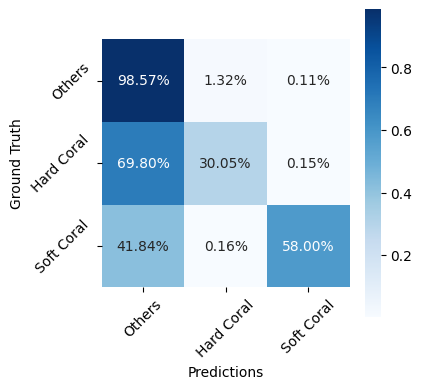

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F
--------------------------------------------------------------------------------
Folder: SEAVIEW_PAC_AUS
# of samples in folder: 118
Loading samples into local working folder ...


  0%|          | 0/118 [00:00<?, ?it/s]

# of samples loaded: 118
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/118 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-SEAVIEW_PAC_AUS', 'execution_tag': 'C0', 'region': 'SEAVIEW_PAC_AUS', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.8358031511306763, 'mpa': 0.5014510750770569, 'pa_class_0': 0.9781376719474792, 'pa_class_1': 0.3978787064552307, 'pa_class_2': 0.1283368021249771, 'miou': 0.4373774230480194, 'iou_class_0': 0.8200950622558594, 'iou_class_1': 0.37035125494003296, 'iou_class_2': 0.12168590724468231, 'mdice': 0.5528819561004639, 'dice_class_0': 0.9011561870574951, 'dice_class_1': 0.5405201315879822, 'dice_class_2': 0.21696965396404266, 'confusion_matrix': [array([[9.7813767e-01, 2.1136736e-02, 7.2561705e-04],
       [6.0097039e-01, 3.9787874e-01, 1.1509297e-03],
       [8.3646315e-01, 3.5200056e-02, 1.2833680e-01]], dtype=float32)]}


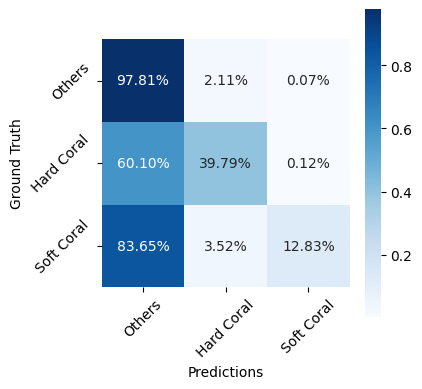

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F
--------------------------------------------------------------------------------
Folder: SEAFLOWER_BOLIVAR
# of samples in folder: 54
Loading samples into local working folder ...


  0%|          | 0/54 [00:00<?, ?it/s]

# of samples loaded: 54
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/54 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-SEAFLOWER_BOLIVAR', 'execution_tag': 'C0', 'region': 'SEAFLOWER_BOLIVAR', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.8534420132637024, 'mpa': 0.6634510159492493, 'pa_class_0': 0.9882630705833435, 'pa_class_1': 0.5118862986564636, 'pa_class_2': 0.49020370841026306, 'miou': 0.6000512838363647, 'iou_class_0': 0.8294907808303833, 'iou_class_1': 0.4963701069355011, 'iou_class_2': 0.4742929935455322, 'mdice': 0.7378831505775452, 'dice_class_0': 0.9067996144294739, 'dice_class_1': 0.663432240486145, 'dice_class_2': 0.6434175372123718, 'confusion_matrix': [array([[9.8826307e-01, 9.6817268e-03, 2.0552541e-03],
       [4.8733696e-01, 5.1188630e-01, 7.7675824e-04],
       [5.0437033e-01, 5.4259384e-03, 4.9020371e-01]], dtype=float32)]}


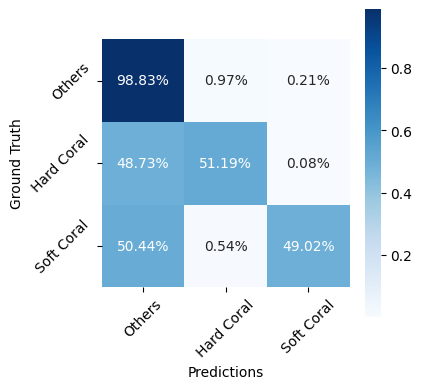

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F
--------------------------------------------------------------------------------
Folder: SEAVIEW_ATL
# of samples in folder: 58
Loading samples into local working folder ...


  0%|          | 0/58 [00:00<?, ?it/s]

# of samples loaded: 58
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/58 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-SEAVIEW_ATL', 'execution_tag': 'C0', 'region': 'SEAVIEW_ATL', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.8795472383499146, 'mpa': 0.6269875168800354, 'pa_class_0': 0.9854540228843689, 'pa_class_1': 0.40543535351753235, 'pa_class_2': 0.4900732636451721, 'miou': 0.5650818943977356, 'iou_class_0': 0.8736078143119812, 'iou_class_1': 0.3730489909648895, 'iou_class_2': 0.44858887791633606, 'mdice': 0.6984248757362366, 'dice_class_0': 0.9325408339500427, 'dice_class_1': 0.543387770652771, 'dice_class_2': 0.619346022605896, 'confusion_matrix': [array([[0.9854539 , 0.00478808, 0.00975794],
       [0.506729  , 0.40543535, 0.08783562],
       [0.4994018 , 0.01052494, 0.49007326]], dtype=float32)]}


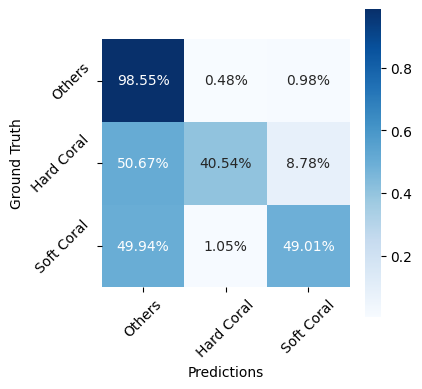

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F
--------------------------------------------------------------------------------
Folder: SEAFLOWER_COURTOWN
# of samples in folder: 49
Loading samples into local working folder ...


  0%|          | 0/49 [00:00<?, ?it/s]

# of samples loaded: 49
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/49 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-SEAFLOWER_COURTOWN', 'execution_tag': 'C0', 'region': 'SEAFLOWER_COURTOWN', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.8495510816574097, 'mpa': 0.4170289635658264, 'pa_class_0': 0.9982315301895142, 'pa_class_1': 0.19700206816196442, 'pa_class_2': 0.055853262543678284, 'miou': 0.3652282655239105, 'iou_class_0': 0.8452282547950745, 'iou_class_1': 0.19546088576316833, 'iou_class_2': 0.05499565228819847, 'mdice': 0.4491286277770996, 'dice_class_0': 0.9161232113838196, 'dice_class_1': 0.3270050883293152, 'dice_class_2': 0.10425759106874466, 'confusion_matrix': [array([[9.9823153e-01, 1.2416798e-03, 5.2685582e-04],
       [8.0152726e-01, 1.9700207e-01, 1.4706427e-03],
       [9.4254726e-01, 1.5994520e-03, 5.5853263e-02]], dtype=float32)]}


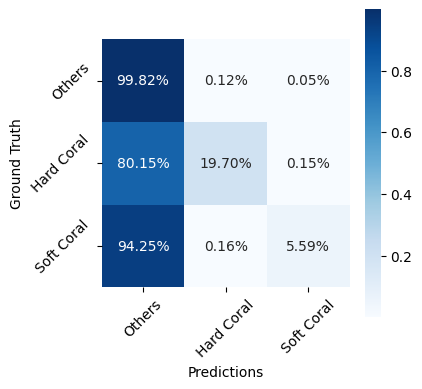

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F
--------------------------------------------------------------------------------
Folder: TETES_PROVIDENCIA
# of samples in folder: 26
Loading samples into local working folder ...


  0%|          | 0/26 [00:00<?, ?it/s]

# of samples loaded: 26
Samples will not be patchified
Propagating labels using SAMPointPromptsLabelProp ...


  0%|          | 0/26 [00:00<?, ?it/s]

Label propagation was successfull for all samples
Evaluation Summary: {'experiment_name': 'SAM-B1-RAND-300-F-TETES_PROVIDENCIA', 'execution_tag': 'C0', 'region': 'TETES_PROVIDENCIA', 'point_labels_source': 'DENSE', 'point_labels_count': 300, 'image_encoder': 'vit_h', 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth', 'pa': 0.8794960379600525, 'mpa': 0.5622923970222473, 'pa_class_0': 0.9776949882507324, 'pa_class_1': 0.2532590627670288, 'pa_class_2': 0.4559231698513031, 'miou': 0.5008277893066406, 'iou_class_0': 0.8767539858818054, 'iou_class_1': 0.24109798669815063, 'iou_class_2': 0.3846314549446106, 'mdice': 0.6261420845985413, 'dice_class_0': 0.9343302845954895, 'dice_class_1': 0.3885236978530884, 'dice_class_2': 0.5555723309516907, 'confusion_matrix': [array([[0.977695  , 0.0023997 , 0.01990524],
       [0.6245715 , 0.25325906, 0.12216945],
       [0.5403946 , 0.00368226, 0.45592317]], dtype=float32)]}


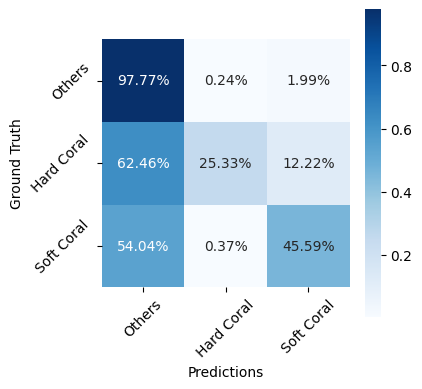

Saving images to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/images ...
Saving masks to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/masks ...
Saving predictions to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F/predictions ...
Data related to the experiment were saved to /content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-RAND-300-F


In [55]:
dataset_full_df = pd.DataFrame({})
patches_dataset_full = []

for folder in dataset_dict.keys():
    logger.info(f"{'-'*80}")
    logger.info(f"Folder: {folder}")

    # get list of quadratids from the dataset
    quadrat_ids = [os.path.splitext(x)[0] for x in dataset_dict[folder]]
    logger.info(f"# of samples in folder: {len(quadrat_ids)}")

    # build a folder specific dataset in the format expected by labelmate package
    dataset_df = create_labelmate_dataset(quadrat_ids, manifest_df, point_labels_source, point_labels_count)

    # append folder specific dataset to full dataset
    dataset_full_df = pd.concat([dataset_full_df, dataset_df], ignore_index=True)

    # setup labelmate dataset
    logger.info(f"Loading samples into local working folder ...")
    label_prop_data = \
        LabelPropDataLoader(
            experiment_name=f"{experiment_name}-{folder}",
            dataset=dataset_df.copy(),
            point_labels=None,
            num_classes=3,
            working_folder=working_folder,
            transforms=get_resize_transform(image_size=image_size),
            )

    # reset working folder contents
    label_prop_data.delete_sub_folders()
    label_prop_data.create_sub_folders()

    # prepare input data in working folders
    label_prop_data.prepare_input_data()
    logger.info(f"# of samples loaded: {len(label_prop_data)}")

    # patchify data if patchifier is provided
    if patchifier:
        logger.info(f"Patchifying samples ...")
        # setup patchifier dataset
        patch_data = \
            patchifier(
                experiment_name=f"{experiment_name}-{folder}",
                samples=label_prop_data,
                num_classes=3,
                working_folder=Path.joinpath(label_prop_data.working_folder, 'patches'),
                patch_height=256,
                patch_width=256,
                step_size=256
            )

        # reset patchifier working folder contents
        patch_data.delete_sub_folders()
        patch_data.create_sub_folders()

        # create patches for samples
        patch_data.patchify_samples()
        logger.info(f"# of patches loaded: {len(patch_data)}")

        # save patch details into a patches dataset
        patch_datatset = \
            [{'dataset_name': folder, 'region': folder, **patch_data[idx]}
            for idx in range(len(patch_data))]

        # append folder specific patches dataset to full patches dataset
        patches_dataset_full.extend(patch_datatset)
    else:
        logger.info(f"Samples will not be patchified")

    # setup label propagator
    logger.info(f"Propagating labels using {propagator.__name__} ...")
    label_propagator = \
        propagator(
            dataloader=patch_data if patchifier else label_prop_data,
            execution_tag=execution_tag,
            hyper_params={'region': folder, **hyper_params},
            )

    # run label propagation
    label_propagator.run_pipeline()

    # plot confusion matrix
    label_propagator.evaluator.plot_confusion_matrix()

    # save experiment data
    label_propagator.save_experiment(
        save_path=Path(RESULTS_UPLOAD_PATH),
        sub_folders=['images', 'masks', 'predictions'],
        )

    # offload propagator from GPU
    if 'SAM' in propagator.__name__:
        del label_propagator.sam_mask_predictor
        del label_propagator.sam_model
        torch.cuda.empty_cache()

    del label_propagator
    torch.cuda.empty_cache()

## Evaluation Metrics

### Evaluation Pipeline

In [56]:
# setup a dummy dataset pointing to the experiment save path
# if patchifier was used, then sample details as well as point labels
# need to be taken from patch dataset related variables
if patchifier:
    label_prop_dummy_dataset = [
        dict(
            sample_id=patches_dataset_full[idx]['sample_id'],
            dataset_name=patches_dataset_full[idx]['dataset_name'],
            region=patches_dataset_full[idx]['region'],
            image_path=os.path.join(RESULTS_UPLOAD_PATH, *(patches_dataset_full[0]['image_path'].parts[-2:])),
            mask_path=os.path.join(RESULTS_UPLOAD_PATH, *(patches_dataset_full[0]['mask_path'].parts[-2:])),
            point_labels_source=point_labels_source,
            point_labels_count=point_labels_count,
        ) for idx in range(len(patches_dataset_full))
    ]
    label_prop_dummy_dataset_df = pd.DataFrame(label_prop_dummy_dataset)
    label_prop_dummy_point_labels_df = \
        pd.concat([patches_dataset_full[idx]['point_labels'] for idx in range(len(patches_dataset_full))], ignore_index=True)
    logger.info(f"# of samples (patches): {label_prop_dummy_dataset_df.shape[0]}")
else:
    label_prop_dummy_dataset_df = dataset_full_df.copy()
    label_prop_dummy_point_labels_df = pd.DataFrame({})
    logger.info(f"# of samples (full images): {label_prop_dummy_dataset_df.shape[0]}")

# of samples (full images): 349


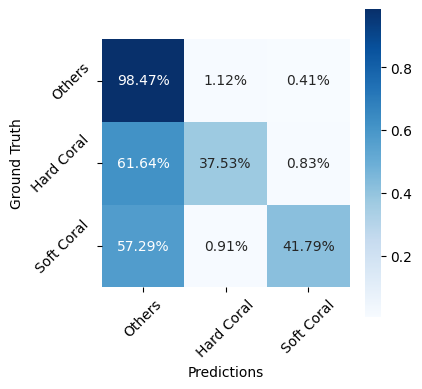

{'experiment_name': 'SAM-B1-RAND-300-F',
 'execution_tag': 'C0',
 'point_labels_source': 'DENSE',
 'point_labels_count': 300,
 'image_encoder': 'vit_h',
 'image_encoder_weights_path': '/content/weights/sam/sam_vit_h_4b8939.pth',
 'pa': 0.8398532867431641,
 'mpa': 0.592628002166748,
 'pa_class_0': 0.9847133159637451,
 'pa_class_1': 0.3752515912055969,
 'pa_class_2': 0.4179190397262573,
 'miou': 0.5231600999832153,
 'iou_class_0': 0.8252838253974915,
 'iou_class_1': 0.3577958345413208,
 'iou_class_2': 0.38640061020851135,
 'mdice': 0.6629066467285156,
 'dice_class_0': 0.9042800664901733,
 'dice_class_1': 0.527024507522583,
 'dice_class_2': 0.5574154853820801,
 'confusion_matrix': [array([[0.98471344, 0.01121499, 0.00407166],
         [0.6164326 , 0.3752516 , 0.00831585],
         [0.57294416, 0.00913679, 0.41791904]], dtype=float32)]}

In [57]:
# setup a dummy dataset pointing to the experiment save path
label_prop_data_dummy = \
    LabelPropDataLoader(
        experiment_name=experiment_name,
        dataset=label_prop_dummy_dataset_df.copy(),
        point_labels=label_prop_dummy_point_labels_df,
        num_classes=3,
        working_folder=Path(RESULTS_UPLOAD_PATH),
        execution_tag=execution_tag,
        transforms=None,
        )

# setup evaluator
label_prop_evaluator = \
    LabelPropEvaluator(
        experiment_name=experiment_name,
        execution_tag=execution_tag,
        num_classes=3,
        hyper_params=hyper_params,
    )

# run evaluator on the dummy dataset
eval_results_samples = label_prop_evaluator.evaluate_samples(label_prop_data_dummy)
eval_results_summary = label_prop_evaluator.generate_summary()

# plot confusion matrix
label_prop_evaluator.plot_confusion_matrix()

# show overall results
eval_results_summary

### Save Evaluation Metrics

In [58]:
label_prop_evaluator.eval_results_summary.to_csv(
    os.path.join(RESULTS_UPLOAD_PATH, f"{experiment_name}-Results-Summary-{execution_tag}.csv"),
    index=False,
    )

In [59]:
label_prop_evaluator.eval_results_samples.to_csv(
    os.path.join(RESULTS_UPLOAD_PATH, f"{experiment_name}-Results-Samples-{execution_tag}.csv"),
    index=False,
    )

## Visualize Results

### Select Samples

In [60]:
sample_ids = [
    '32011066301',
    '12025020201',
    '20046281801',
    '20220914_AnB_CB14 (219)',
    'E19_T2_C11_Corr_22sep22',
    'G0088441',
    ]
# sample_ids = ['17001652802', '12025020201', '24047242502']

if patchifier:
    sample_ids = label_prop_dummy_point_labels_df.query(f"sample_id.isin({sample_ids})").quadratid.unique().tolist()

### Plot Results

Sample ID: 32011066301, Region: SEAVIEW_IDN_PHL
IoU - Hard Coral = 0.00%, IoU - Soft Coral = 27.03%
PA - Hard Coral = 0.00%, PA - Soft Coral = 29.30%


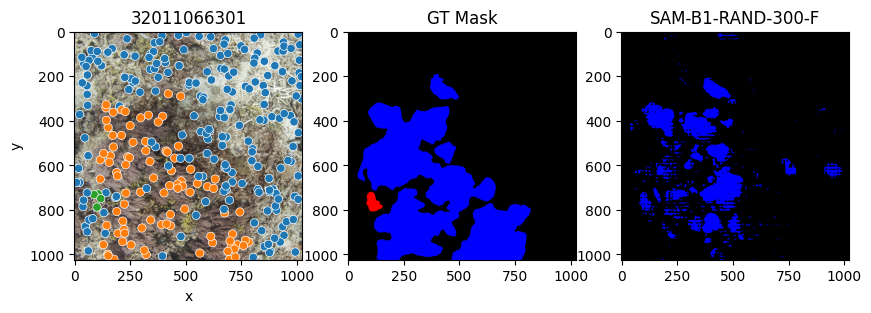



Sample ID: 12025020201, Region: SEAVIEW_PAC_AUS
IoU - Hard Coral = 47.23%, IoU - Soft Coral = 0.00%
PA - Hard Coral = 56.08%, PA - Soft Coral = 0.00%


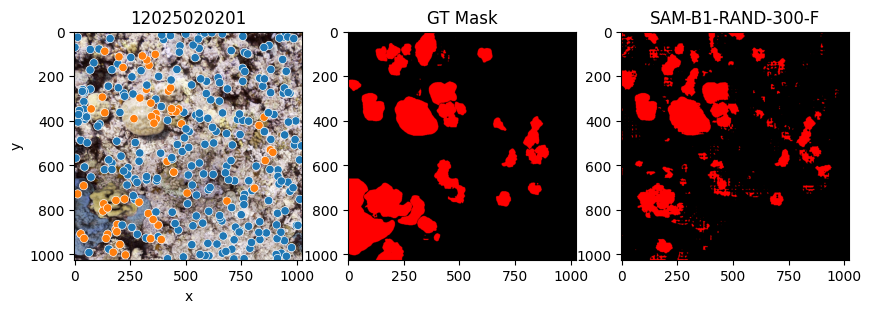



Sample ID: 20046281801, Region: SEAVIEW_ATL
IoU - Hard Coral = 0.00%, IoU - Soft Coral = 27.33%
PA - Hard Coral = 0.00%, PA - Soft Coral = 37.07%


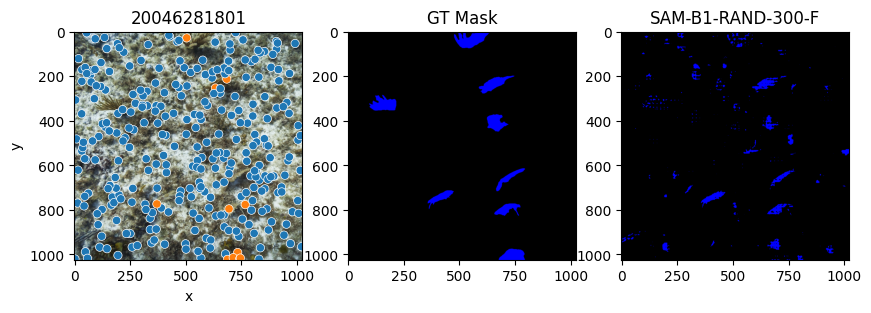



Sample ID: 20220914_AnB_CB14 (219), Region: SEAFLOWER_BOLIVAR
IoU - Hard Coral = 38.94%, IoU - Soft Coral = 30.21%
PA - Hard Coral = 39.81%, PA - Soft Coral = 31.00%


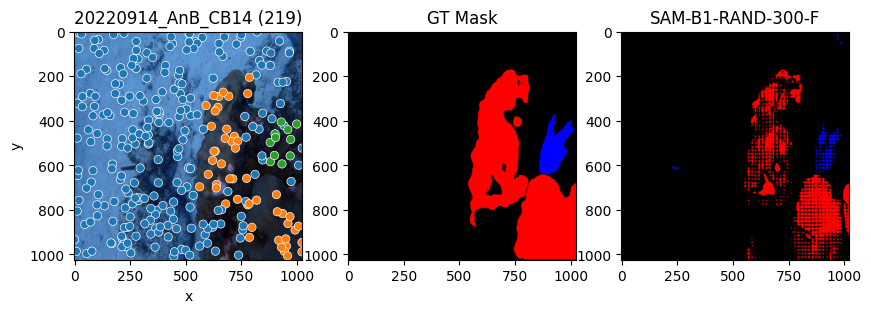



Sample ID: E19_T2_C11_Corr_22sep22, Region: SEAFLOWER_COURTOWN
IoU - Hard Coral = 6.58%, IoU - Soft Coral = 0.00%
PA - Hard Coral = 6.59%, PA - Soft Coral = 0.00%


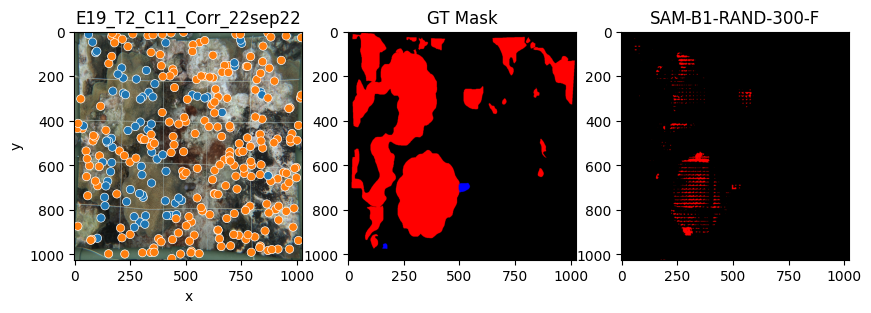



Sample ID: G0088441, Region: TETES_PROVIDENCIA
IoU - Hard Coral = 0.00%, IoU - Soft Coral = 11.50%
PA - Hard Coral = 0.00%, PA - Soft Coral = 12.08%


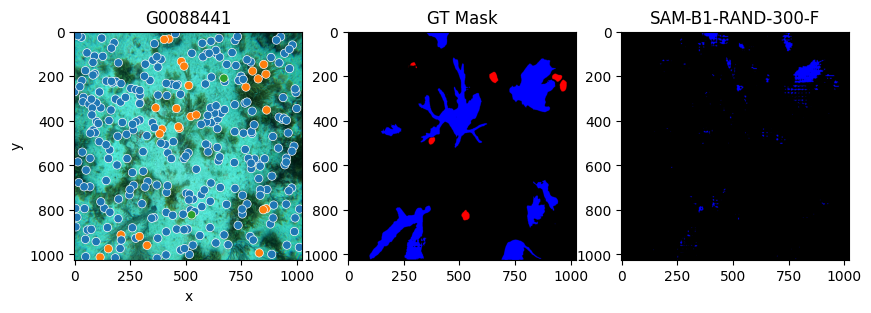

In [61]:
for sample_id in sample_ids:
    index = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").index.item()
    manifest_index = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").manifest_index.item()
    region = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").dataset_name.item()
    point_labels_source = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").point_labels_source.item()
    point_labels_count = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").point_labels_count.item()

    if label_prop_dummy_point_labels_df.shape[0] == 0:
        if point_labels_source == 'GRID':
            point_labels = \
                label_prop_data_dummy.get_evenly_spaced_point_labels(
                    mask_path=str(Path(label_prop_data_dummy[index]['mask_path']).resolve()),
                    num_point_labels=point_labels_count,
                    )
        else:
            point_labels = \
                label_prop_data_dummy.get_random_point_labels(
                    mask_path=str(Path(label_prop_data_dummy[index]['mask_path']).resolve()),
                    num_point_labels=point_labels_count,
                    random_seed=manifest_index,
                    )
        point_labels_df = pd.DataFrame(point_labels)
        point_labels_df['quadratid'] = sample_id
    else:
        point_labels_df = label_prop_dummy_point_labels_df.copy()

    evaluation_metrics = \
        label_prop_evaluator.eval_results_samples.query(f"sample_id == '{sample_id}'")

    print(f"Sample ID: {sample_id}, Region: {region}")
    print(f"IoU - Hard Coral = {evaluation_metrics.iou_class_1.item():.2%}, IoU - Soft Coral = {evaluation_metrics.iou_class_2.item():.2%}")
    print(f"PA - Hard Coral = {evaluation_metrics.pa_class_1.item():.2%}, PA - Soft Coral = {evaluation_metrics.pa_class_2.item():.2%}")

    visualize_output(
        experiment_name=label_prop_data_dummy[index]['experiment_name'],
        sample_id=label_prop_data_dummy[index]['sample_id'],
        image_path=Path(label_prop_data_dummy[index]['image_path']),
        mask_path=Path(label_prop_data_dummy[index]['mask_path']),
        prediction_path=Path(label_prop_data_dummy[index]['prediction_path']),
        point_labels=point_labels_df,
        )

    print()
    print()

Sample ID: 17001652802, Region: SEAVIEW_ATL
IoU - Hard Coral = 50.94%, IoU - Soft Coral = 47.90%
PA - Hard Coral = 59.29%, PA - Soft Coral = 48.64%


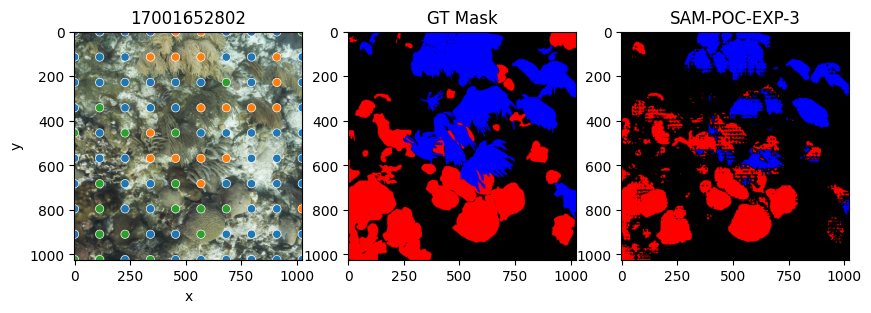



Sample ID: 12025020201, Region: SEAVIEW_PAC_AUS
IoU - Hard Coral = 45.70%, IoU - Soft Coral = 0.00%
PA - Hard Coral = 55.94%, PA - Soft Coral = 0.00%


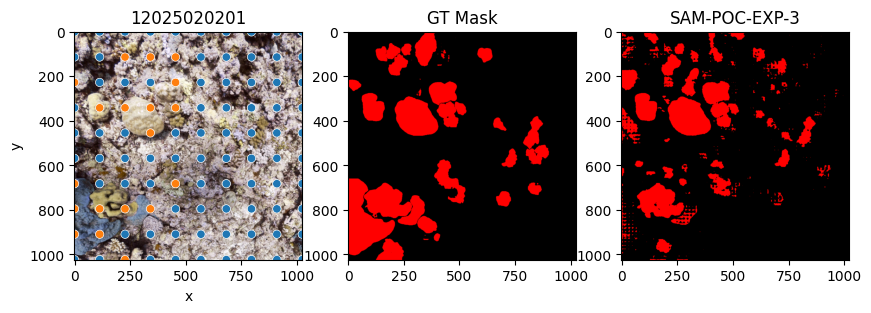



Sample ID: 24047242502, Region: SEAVIEW_ATL
IoU - Hard Coral = 23.25%, IoU - Soft Coral = 17.47%
PA - Hard Coral = 23.29%, PA - Soft Coral = 18.24%


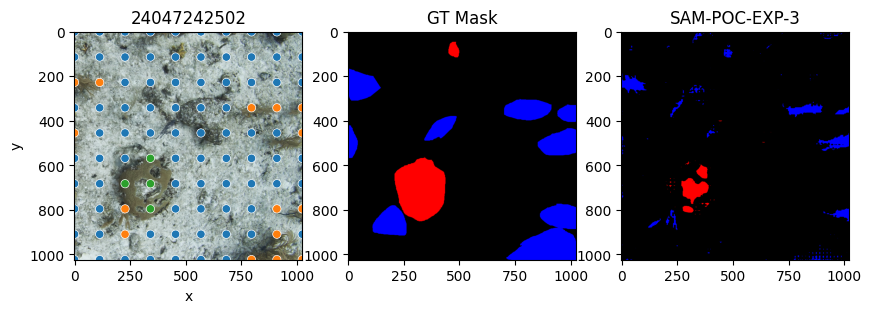

Sample ID: 17001652802, Region: SEAVIEW_ATL
IoU - Hard Coral = 29.38%, IoU - Soft Coral = 67.49%
PA - Hard Coral = 32.33%, PA - Soft Coral = 75.83%


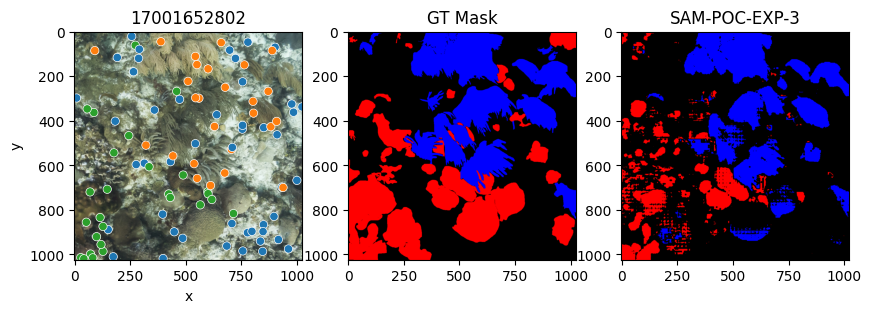



Sample ID: 12025020201, Region: SEAVIEW_PAC_AUS
IoU - Hard Coral = 64.58%, IoU - Soft Coral = 0.00%
PA - Hard Coral = 73.88%, PA - Soft Coral = 0.00%


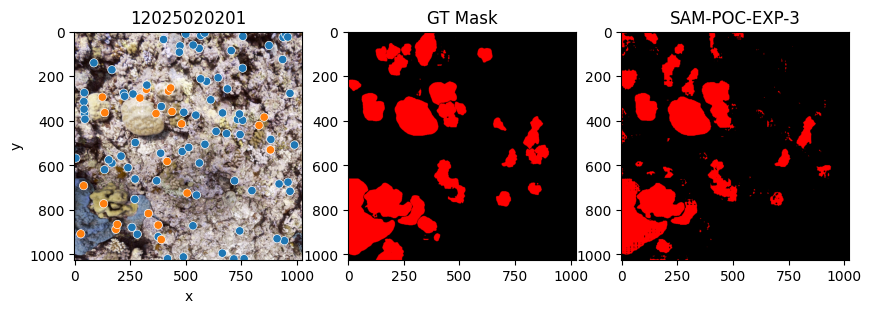



Sample ID: 24047242502, Region: SEAVIEW_ATL
IoU - Hard Coral = 36.59%, IoU - Soft Coral = 18.10%
PA - Hard Coral = 38.46%, PA - Soft Coral = 19.99%


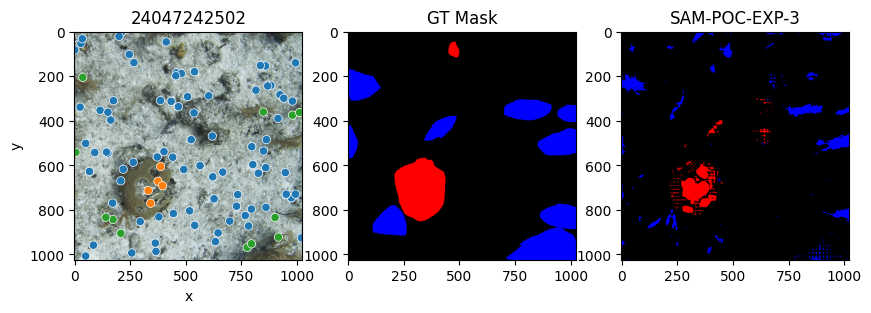

## YOLOv8 Comparison

### Select Samples

In [ ]:
sample_ids = [
    '32011066301',
    '12025020201',
    '20046281801',
    '20220914_AnB_CB14 (219)',
    'E19_T2_C11_Corr_22sep22',
    'G0088441',
    ]
# sample_ids = ['17001652802', '12025020201', '24047242502']
sample_ids = ['20010148701', '17039238402', '10001026902']

if patchifier:
    sample_ids = label_prop_dummy_point_labels_df.query(f"sample_id.isin({sample_ids})").quadratid.unique().tolist()

In [ ]:
# setup a dummy dataset pointing to the experiment save path
label_prop_data_dummy = \
    LabelPropDataLoader(
        experiment_name=experiment_name,
        dataset=label_prop_dummy_dataset_df.copy(),
        point_labels=label_prop_dummy_point_labels_df,
        num_classes=3,
        working_folder=Path(RESULTS_UPLOAD_PATH),
        execution_tag=execution_tag,
        transforms=None,
        )

### Plot Results

In [ ]:
for sample_id in sample_ids:
    index = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").index.item()
    manifest_index = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").manifest_index.item()
    region = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").dataset_name.item()
    point_labels_source = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").point_labels_source.item()
    point_labels_count = label_prop_dummy_dataset_df.query(f"sample_id == '{sample_id}'").point_labels_count.item()

    if label_prop_dummy_point_labels_df.shape[0] == 0:
        if point_labels_source == 'GRID':
            point_labels = \
                label_prop_data_dummy.get_evenly_spaced_point_labels(
                    mask_path=str(Path(label_prop_data_dummy[index]['mask_path']).resolve()),
                    num_point_labels=point_labels_count,
                    )
        else:
            point_labels = \
                label_prop_data_dummy.get_random_point_labels(
                    mask_path=str(Path(label_prop_data_dummy[index]['mask_path']).resolve()),
                    num_point_labels=point_labels_count,
                    random_seed=manifest_index,
                    )
        point_labels_df = pd.DataFrame(point_labels)
        point_labels_df['quadratid'] = sample_id
    else:
        point_labels_df = label_prop_dummy_point_labels_df.copy()

    evaluation_metrics = \
        label_prop_evaluator.eval_results_samples.query(f"sample_id == '{sample_id}'")

    print(f"Sample ID: {sample_id}, Region: {region}")
    print(f"IoU - Hard Coral = {evaluation_metrics.iou_class_1.item():.2%}, IoU - Soft Coral = {evaluation_metrics.iou_class_2.item():.2%}")
    print(f"PA - Hard Coral = {evaluation_metrics.pa_class_1.item():.2%}, PA - Soft Coral = {evaluation_metrics.pa_class_2.item():.2%}")

    visualize_output(
        experiment_name=label_prop_data_dummy[index]['experiment_name'],
        sample_id=label_prop_data_dummy[index]['sample_id'],
        image_path=Path(label_prop_data_dummy[index]['image_path']),
        mask_path=Path(label_prop_data_dummy[index]['mask_path']),
        prediction_path=Path(label_prop_data_dummy[index]['prediction_path']),
        point_labels=point_labels_df,
        )

    print()
    print()

KeyError: 255

In [ ]:
quadrat_ids = ['20010148701', '17039238402', '10001026902']

In [ ]:
dataset_df = create_labelmate_dataset(quadrat_ids, manifest_df, point_labels_source, point_labels_count)

In [ ]:
label_prop_data = \
    LabelPropDataLoader(
        experiment_name=f"{experiment_name}-{folder}",
        dataset=dataset_df.copy(),
        point_labels=point_labels_df,
        num_classes=3,
        execution_tag='C0',
        working_folder=Path(RESULTS_UPLOAD_PATH),
        transforms=get_resize_transform(image_size=image_size),
        )

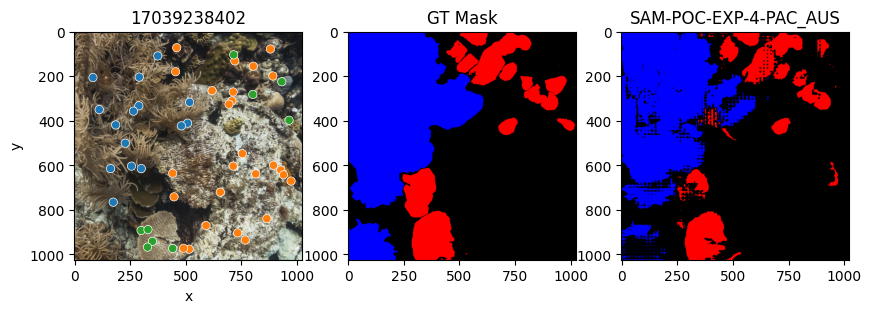

In [ ]:
index = 1
visualize_output(
    experiment_name=label_prop_data[index]['experiment_name'],
    sample_id=label_prop_data[index]['sample_id'],
    image_path=Path(label_prop_data[index]['image_path']),
    mask_path=Path(label_prop_data[index]['mask_path']),
    prediction_path=Path(label_prop_data[index]['prediction_path']),
    point_labels=point_labels_df,
    )

In [ ]:
os.path.exists(Path(label_prop_data[0]['prediction_path']))

False

In [ ]:
Path(label_prop_data[2]['prediction_path'])

PosixPath('/content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-V1/predictions/10001026902-C0.png')

In [ ]:
os.path.exists('/content/drive/MyDrive/20231114-FruitPunch-AI-for-Coral-Reefs-2/findings/SAM-B1-V2/predictions/10001026902-C0.png')

True